Previously, I showed that we can remove the annual cycle from a given variable in either NumPy or Xarray. Now, I want to analyze how well that removal worked, and whether there is any lingering signal.

A note on plotting: throughout this repository, it is helpful to keep in mind that negative pressure velocity, $\omega$, is actually the upward movement of air and that positive omege denotes downward movement. With that said, I have tried to be consistent in coloring plots, always keeping -$\omega$ blue and positive $\omega$ red. So when you see blue, think "up".

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import cmocean

from plotting import *

In [2]:
#constants declaration
#lat1 < lat2
lat1 = -20
lat2 = 20
lat_lims = [lat1,lat2]

#variable files on disk
omega_file = './data/omega_7917.npy'
omega_anom_file = './data/omega_anom_7917.npy'
lon_file = './data/lon.npy'
lat_file = './data/lat.npy'
p_file = './data/p.npy'
time_file = './data/time.npy'

#x axis labels: longitude
lon_list = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 239]
lon_list_labels = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 358.5]

lon_list_small = [80, 100, 120, 140, 160, 180]
lon_list_labels_small = [120., 150., 180., 210., 240., 270.]

shifted_lon_list = [60, 80, 100, 120, 140, 160, 180, 200, 220, 239, 0, 20, 40]
shifted_lon_list_labels = [90, 120, 150, 180, 210, 240, 270, 300, 330, 358.5, 0, 30, 60]
shifted_labels_eastWest = ['90E', '120E', '150E', '180', '150W', '120W', '90W', '60W', '30W', '0', '30E', '60E', '90E']

#y axis labels: time
year_ticks = np.arange(1, 468, 12)

#for plotting
colormap = cmocean.cm.balance
colorbar_label = r"$Pa \hspace{1} s^{-1}$"

#left and right titles
left_title_diff = '[$-\omega + \omega$]'
right_title_diff = '1989-2007'
right_title_diff_full = '1979-2017'

#axis labels
p_label = 'Pressure (mb)'
z_label = 'Height (km)'

title = 'Longitude-Time Plot for $\omega$ at 500hPa, Before Removing Annual Cycle'
title_anom = 'Longitude-Time Plot for $\omega$ at 500hPa, Annual Cycle Removed'

figure_name = 'hovmoller'+str(lat_lims[0])+'_'+str(lat_lims[1])+'.pdf'
figure_name_anom = 'hovmoller'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_anomaly.pdf'

### Data Import

In [3]:
#read in data files
omega = np.load(omega_file)
omega_anom = np.load(omega_anom_file)

lon = np.load(lon_file)
lat = np.load(lat_file)
p = np.load(p_file)
time = np.load(time_file)
time = pd.to_datetime(time)

### Data Processing

In [4]:
#for boolean indexing
latidx = (lat >=lat_lims[0] ) & (lat <=lat_lims[1] )

#only take pressures greater than 10hPa (for plotting purposes)
pidx = 21

#subset new matrices for correct latitude, pressure ranges
omega_lat = omega[:, :, latidx, :]
omega_lat_p = omega_lat[:, pidx, :, :]

#we are subsetting for latitudes of interest, but also a particular pressure level
omega_anom_lat = omega_anom[:, :, latidx, :]
omega_anom_lat_p = omega_anom_lat[:, pidx, :, :]

In [5]:
#create cos(lat) matrix
cos_lat = np.asmatrix(np.cos(np.deg2rad(lat[latidx]))).T
cos_lat_matrix = np.multiply(np.ones((27,240)), cos_lat)

#weight by cos(lat)
omega_weight = np.multiply(omega_lat_p, np.array(cos_lat_matrix))
anom_weight = np.multiply(omega_anom_lat_p, np.array(cos_lat_matrix))

#average over latitude; now dimensions should be (time, longitude)
omega_latmean = np.mean(omega_weight, axis=1)
anom_latmean = np.mean(anom_weight, axis=1)

### Plotting

For reference, 270E is around the coast of South America, while 210E is off the coast of the United States.

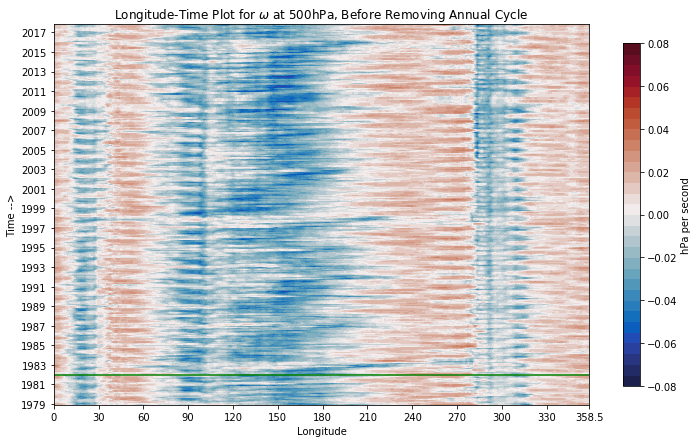

In [6]:
#let's create a hovmoller plot (time vs longitude) of the omega variable
vmin = -0.08
vmax = 0.085
contours = np.arange(vmin, vmax, 0.005)

plot_hovmoller(omega_latmean, vmin, vmax, contours, colormap, lon_list, lon_list_labels, 
               year_ticks, time.year, 37, title, figure_name, False)

A list of past El Niño/La Niña events can be found here: https://www.esrl.noaa.gov/psd/enso/past_events.html. Some of the El Niño years in the data that show up when we plot the anomaly data are: 1983, 1987-1988, 1992, 1998, and the big 2015-2016 event. Warmer SSTs will lead to more convection, so we would expect more upward movement of air during large El Niño events.

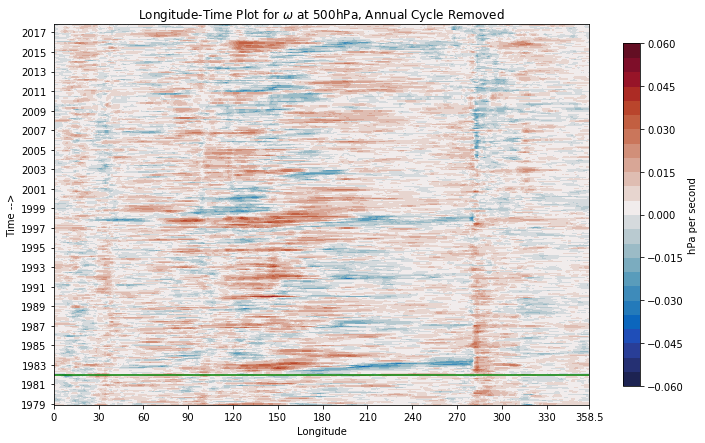

In [8]:
vmin2 = -0.06
vmax2 = 0.065
contours2 = np.arange(vmin2, vmax2, 0.005)

plot_hovmoller(anom_latmean, vmin2, vmax2, contours2, colormap, lon_list, lon_list_labels, 
               year_ticks, time.year, 37, title_anom, figure_name_anom, False)

Zooming in a bit on the Pacific Ocean can help us see the events a little bit better.

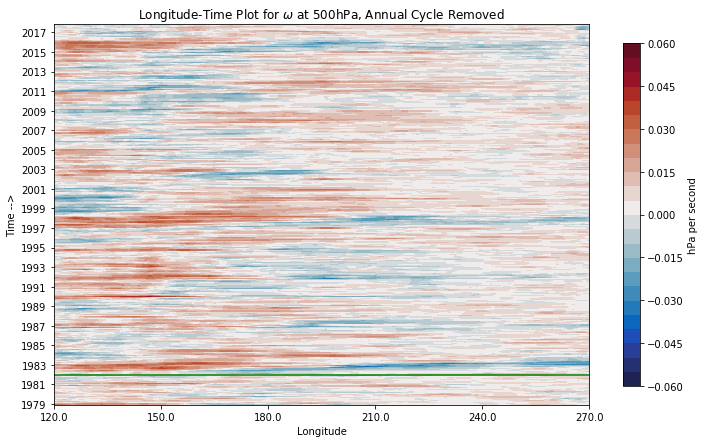

In [9]:
plot_hovmoller(anom_latmean[:, 80:181], vmin2, vmax2, contours2, colormap, [0, 20, 40, 60, 80, 100], lon_list_labels_small, 
               year_ticks, time.year, 37, title_anom, figure_name_anom, False)

So we have correctly taken out the annual cycle from out data, but there is still some sub-annual cycle included that is behaving a lot like El Niño. We will have to filter this signal out if we want to get at the heart of what is causing the shallow vs deep convection in the Eastern and Western Pacific. Otherwise, the signal that we care about is likely to be dominated by El Niño.